# Gesture Recognition for Smart TVs

In [27]:
# Import the libraries

import numpy as np
import matplotlib.pyplot as plt
import os
import imageio.v2 as imageio
import skimage
from skimage.transform import resize
import datetime
import cv2
import abc
import warnings
warnings.filterwarnings("ignore")
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Flatten, TimeDistributed, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from keras import backend as K
from keras.applications import mobilenet
import tensorflow as tf
import random as rn

In [2]:
# Setting the random state to replicate the output

np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In [3]:
# Add the root folder name as base path
base_path = 'Project_data'

### Helper classes and functions

In [4]:
class ModelBuilder(metaclass=abc.ABCMeta):
    """
    Abstract base class for building models and data generators.
    """

    def initialize_path(self, base_path):
        """
        Initialize paths for training and validation data.

        Args:
        - base_path (str): Base directory path containing train.csv and val.csv.

        Returns:
        - None
        """
        self.train_doc = np.random.permutation(open(base_path + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(base_path + '/' + 'val.csv').readlines())
        self.train_path = base_path + '/' + 'train'
        self.val_path = base_path + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_props(self, image_height=100, image_width=100):
        """
        Initialize properties related to images.

        Args:
        - image_height (int): Height of the images.
        - image_width (int): Width of the images.

        Returns:
        - None
        """
        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30
          
    def initialize_hyperparameters(self, number_of_sample_frames=30, batch_size=20, num_epochs=20):
        """
        Initialize hyperparameters for training.

        Args:
        - number_of_sample_frames (int): Number of sample frames.
        - batch_size (int): Batch size for training.
        - num_epochs (int): Number of epochs for training.

        Returns:
        - None
        """
        self.number_of_sample_frames = number_of_sample_frames
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
        
    def generator(self, source_path, folder_list, augment=False):
        """
        Generator function for creating batches of data.

        Args:
        - source_path (str): Path to the source directory containing video frames.
        - folder_list (list): List of folders containing video frames.
        - augment (bool): Whether to perform data augmentation.

        Yields:
        - batch_data (numpy array): Batch of input data.
        - batch_labels (numpy array): Batch of corresponding labels.
        """
        img_idx = np.round(np.linspace(0, self.total_frames - 1, self.number_of_sample_frames, dtype=int))
        batch_size = self.batch_size
        
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels = self.one_batch_data(source_path, t, batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels 

            remaining_samples = len(t) % batch_size
        
            if (remaining_samples != 0):
                batch_data, batch_labels = self.one_batch_data(source_path, t, num_batches, batch_size, img_idx, augment, remaining_samples)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_samples=0):
        """
        Fetch one batch of data.

        Args:
        - source_path (str): Path to the source directory containing video frames.
        - t (list): List of folders containing video frames.
        - batch (int): Batch index.
        - batch_size (int): Batch size.
        - img_idx (numpy array): Indices of frames to be considered.
        - augment (bool): Whether to perform data augmentation.
        - remaining_samples (int): Number of remaining samples in the last batch.

        Returns:
        - batch_data (numpy array): Batch of input data.
        - batch_labels (numpy array): Batch of corresponding labels.
        """
    
        seq_length = remaining_samples if remaining_samples else batch_size
    
        batch_data = np.zeros((seq_length, len(img_idx), self.image_height, self.image_width, self.channels)) 
        batch_labels = np.zeros((seq_length, self.num_classes)) 
    
        if (augment):
            batch_data_aug = np.zeros((seq_length, len(img_idx), self.image_height, self.image_width, self.channels))

        
        for folder in range(seq_length): 
            imgs = os.listdir(source_path + '/' + t[folder + (batch*batch_size)].split(';')[0]) 
            for idx, item in enumerate(img_idx): 
                image = imageio.imread(source_path + '/' + t[folder + (batch*batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                image_resized = resize(image, (self.image_height, self.image_width, 3))
            
            
                # Normalization of RGB channels
                batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0])/255
                batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1])/255
                batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)], [0, 1, np.random.randint(-30, 30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped = shifted[x0:x1, y0:y1, :]
                    
                    image_resized = resize(cropped, (self.image_height, self.image_width, 3))
            
                    batch_data_aug[folder, idx, :, :, 0] = (image_resized[:, :, 0])/255
                    batch_data_aug[folder, idx, :, :, 1] = (image_resized[:, :, 1])/255
                    batch_data_aug[folder, idx, :, :, 2] = (image_resized[:, :, 2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])

        
        return(batch_data, batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        """
        Train the model.

        Args:
        - model: Model to be trained.
        - augment_data (bool): Whether to augment the training data.

        Returns:
        - history: Training history.
        """
        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        # Create a directory with model name and current datetime
        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ', '').replace(':', '_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        # Generate model file inside the created folder
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

        # Add model checkpoint
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
        
        # Add learning rate
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        # Calculate steps per epoch
        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        # Fit the model
        history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def model_definition(self):
        """
        Abstract method for defining the model architecture.
        """
        pass


In [5]:
def plot(history):
    """
    Plots training and validation loss, as well as categorical accuracy and validation categorical accuracy.

    Args:
    - history: History object returned by model.fit(), containing training metrics.

    Returns:
    - None
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss', 'val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy', 'val_categorical_accuracy'])

### Model 1 - CNN with LSTM + RNN

In [6]:
class RNNCNN1(ModelBuilder):
    
    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
            input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimizer = tf.keras.optimizers.legacy.Adam()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [9]:
rnn_cnn_1 = RNNCNN1()
rnn_cnn_1.initialize_path(base_path)
rnn_cnn_1.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_1.initialize_hyperparameters(number_of_sample_frames=18, batch_size=20, num_epochs=20)
rnn_cnn_model_1 = rnn_cnn_1.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeD  (None, 18, 120, 120, 16   448       
 istributed)                 )                                   
                                                                 
 time_distributed_17 (TimeD  (None, 18, 120, 120, 16   64        
 istributed)                 )                                   
                                                                 
 time_distributed_18 (TimeD  (None, 18, 60, 60, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_19 (TimeD  (None, 18, 60, 60, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_20 (TimeD  (None, 18, 60, 60, 32)   

In [10]:
print("Total Parameters: ", rnn_cnn_model_1.count_params())
model_1 = rnn_cnn_1.train_model(rnn_cnn_model_1, augment_data=True)

Total Parameters:  1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4431 - categorical_accuracy: 0.3665
Epoch 1: saving model to model_init_2024-04-0118_58_07.612618/model-00001-1.44309-0.36652-1.65488-0.21000.keras
34/34 [==============================] - 175s 5s/step - loss: 1.4431 - categorical_accuracy: 0.3665 - val_loss: 1.6549 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1679 - categorical_accuracy: 0.5294
Epoch 2: saving model to model_init_2024-04-0118_58_07.612618/model-00002-1.16792-0.52941-2.23778-0.17000.keras
34/34 [==============================] - 170s 5s/step - loss: 1.1679 - categorical_accuracy: 0.5294 - val_loss: 2.2378 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0110 - categorical_accuracy: 0.5920
Epoch 3: saving model to model_init_2024-04-0118_58_07.612618/model-00003-1.01100-0.59201-2.60089

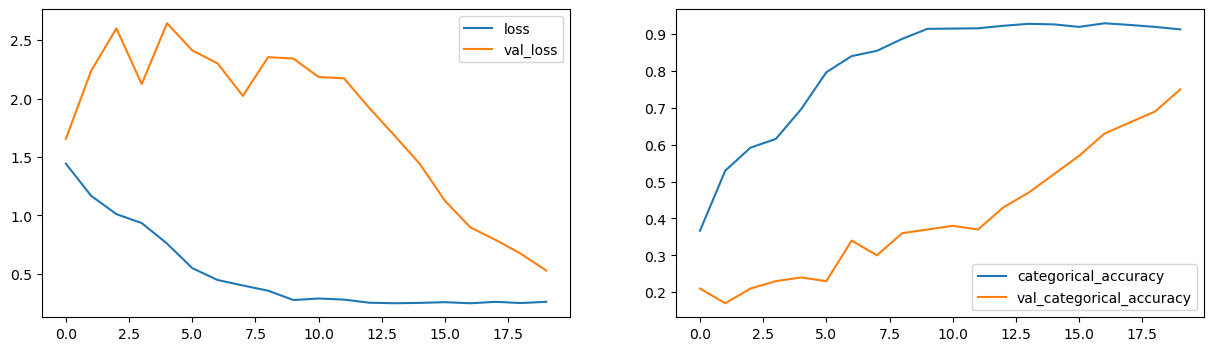

In [13]:
plot(model_1)

***Observations:***

The training accuracy shows a steady rise, reaching 92.91%, while the validation accuracy peaks at 75%, suggesting potential overfitting.

### Model 2 - CNN with GRU + RNN

In [14]:
class RNNCNN2(ModelBuilder):
    
    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
            input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [15]:
rnn_cnn_2 = RNNCNN2()
rnn_cnn_2.initialize_path(base_path)
rnn_cnn_2.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_2.initialize_hyperparameters(number_of_sample_frames=18, batch_size=20, num_epochs=20)
rnn_cnn_model_2 = rnn_cnn_2.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeD  (None, 18, 120, 120, 16   448       
 istributed)                 )                                   
                                                                 
 time_distributed_33 (TimeD  (None, 18, 120, 120, 16   64        
 istributed)                 )                                   
                                                                 
 time_distributed_34 (TimeD  (None, 18, 60, 60, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_35 (TimeD  (None, 18, 60, 60, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_36 (TimeD  (None, 18, 60, 60, 32)   

In [17]:
print("Total Parameters: ", rnn_cnn_model_2.count_params())
model_2 = rnn_cnn_2.train_model(rnn_cnn_model_2, augment_data=True)

Total Parameters:  2573925
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4813 - categorical_accuracy: 0.3612
Epoch 1: saving model to model_init_2024-04-0119_55_04.140460/model-00001-1.48126-0.36124-1.82918-0.22000.keras
34/34 [==============================] - 173s 5s/step - loss: 1.4813 - categorical_accuracy: 0.3612 - val_loss: 1.8292 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0602 - categorical_accuracy: 0.5799
Epoch 2: saving model to model_init_2024-04-0119_55_04.140460/model-00002-1.06019-0.57994-2.25703-0.21000.keras
34/34 [==============================] - 158s 5s/step - loss: 1.0602 - categorical_accuracy: 0.5799 - val_loss: 2.2570 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8618 - categorical_accuracy: 0.6697
Epoch 3: saving model to model_init_2024-04-0119_55_04.140460/model-00003-0.86178-0.66968

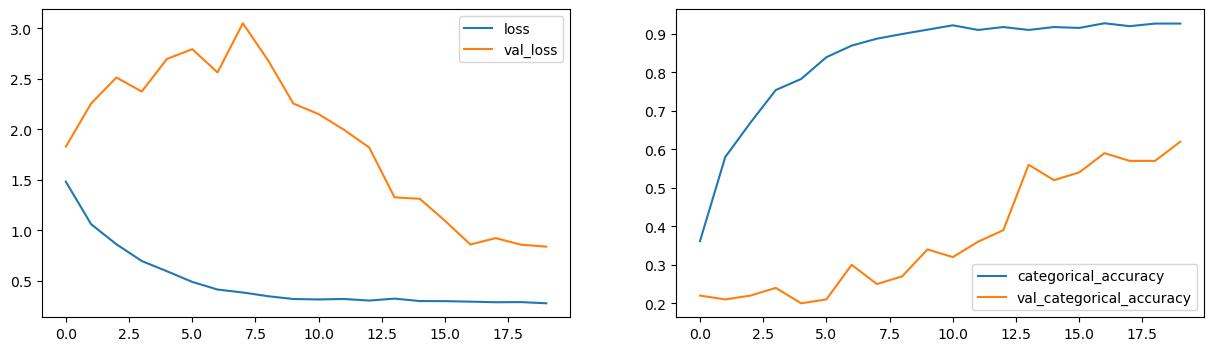

In [18]:
plot(model_2)

***Observations:***

Through the implementation of GRU-RNN, the training accuracy sees a slight enhancement, reaching 92.6%, while the validation accuracy remains stagnant at 62%, signifying overfitting.

### Modify Model Builder class to include rotation

In [20]:
class ModelBuilderWithRotation(metaclass=abc.ABCMeta):
    """
    Abstract base class for building models and data generators.
    """

    def initialize_path(self, base_path):
        """
        Initialize paths for training and validation data.

        Args:
        - base_path (str): Base directory path containing train.csv and val.csv.

        Returns:
        - None
        """
        self.train_doc = np.random.permutation(open(base_path + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(base_path + '/' + 'val.csv').readlines())
        self.train_path = base_path + '/' + 'train'
        self.val_path = base_path + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_props(self, image_height=100, image_width=100):
        """
        Initialize properties related to images.

        Args:
        - image_height (int): Height of the images.
        - image_width (int): Width of the images.

        Returns:
        - None
        """
        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30
          
    def initialize_hyperparameters(self, number_of_sample_frames=30, batch_size=20, num_epochs=20):
        """
        Initialize hyperparameters for training.

        Args:
        - number_of_sample_frames (int): Number of sample frames.
        - batch_size (int): Batch size for training.
        - num_epochs (int): Number of epochs for training.

        Returns:
        - None
        """
        self.number_of_sample_frames = number_of_sample_frames
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
        
    def generator(self, source_path, folder_list, augment=False):
        """
        Generator function for creating batches of data.

        Args:
        - source_path (str): Path to the source directory containing video frames.
        - folder_list (list): List of folders containing video frames.
        - augment (bool): Whether to perform data augmentation.

        Yields:
        - batch_data (numpy array): Batch of input data.
        - batch_labels (numpy array): Batch of corresponding labels.
        """
        img_idx = np.round(np.linspace(0, self.total_frames - 1, self.number_of_sample_frames, dtype=int))
        batch_size = self.batch_size
        
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels = self.one_batch_data(source_path, t, batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels 

            remaining_samples = len(t) % batch_size
        
            if (remaining_samples != 0):
                batch_data, batch_labels = self.one_batch_data(source_path, t, num_batches, batch_size, img_idx, augment, remaining_samples)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_samples=0):
        """
        Fetch one batch of data.

        Args:
        - source_path (str): Path to the source directory containing video frames.
        - t (list): List of folders containing video frames.
        - batch (int): Batch index.
        - batch_size (int): Batch size.
        - img_idx (numpy array): Indices of frames to be considered.
        - augment (bool): Whether to perform data augmentation.
        - remaining_samples (int): Number of remaining samples in the last batch.

        Returns:
        - batch_data (numpy array): Batch of input data.
        - batch_labels (numpy array): Batch of corresponding labels.
        """
    
        seq_length = remaining_samples if remaining_samples else batch_size
    
        batch_data = np.zeros((seq_length, len(img_idx), self.image_height, self.image_width, self.channels)) 
        batch_labels = np.zeros((seq_length, self.num_classes)) 
    
        if (augment):
            batch_data_aug = np.zeros((seq_length, len(img_idx), self.image_height, self.image_width, self.channels))

        
        for folder in range(seq_length): 
            imgs = os.listdir(source_path + '/' + t[folder + (batch*batch_size)].split(';')[0]) 
            for idx, item in enumerate(img_idx): 
                image = imageio.imread(source_path + '/' + t[folder + (batch*batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)
                image_resized = resize(image, (self.image_height, self.image_width, 3))
            
            
                # Normalization of RGB channels
                batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0])/255
                batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1])/255
                batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)], [0, 1, np.random.randint(-30, 30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped = shifted[x0:x1, y0:y1, :]
                    
                    image_resized = resize(cropped, (self.image_height, self.image_width, 3))
                    
                    matrix2d = cv2.getRotationMatrix2D((self.image_width//2, self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, matrix2d, (self.image_width, self.image_height))
            
                    batch_data_aug[folder, idx, :, :, 0] = (rotated[:, :, 0])/255
                    batch_data_aug[folder, idx, :, :, 1] = (rotated[:, :, 1])/255
                    batch_data_aug[folder, idx, :, :, 2] = (rotated[:, :, 2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])

        
        return(batch_data, batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        """
        Train the model.

        Args:
        - model: Model to be trained.
        - augment_data (bool): Whether to augment the training data.

        Returns:
        - history: Training history.
        """
        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        # Create a directory with model name and current datetime
        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ', '').replace(':', '_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        # Generate model file inside the created folder
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

        # Add model checkpoint
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
        
        # Add learning rate
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        # Calculate steps per epoch
        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences % self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        # Fit the model
        history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def model_definition(self):
        """
        Abstract method for defining the model architecture.
        """
        pass


### Model 3 - LSTM + RNN with modified Augmentation Technique

In [23]:
class RNNCNN3(ModelBuilderWithRotation):
    
    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
            input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimizer = tf.keras.optimizers.legacy.Adam()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [24]:
rnn_cnn_3 = RNNCNN3()
rnn_cnn_3.initialize_path(base_path)
rnn_cnn_3.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_3.initialize_hyperparameters(number_of_sample_frames=18, batch_size=20, num_epochs=20)
rnn_cnn_model_3 = rnn_cnn_3.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_45 (TimeD  (None, 18, 120, 120, 16   448       
 istributed)                 )                                   
                                                                 
 time_distributed_46 (TimeD  (None, 18, 120, 120, 16   64        
 istributed)                 )                                   
                                                                 
 time_distributed_47 (TimeD  (None, 18, 60, 60, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_48 (TimeD  (None, 18, 60, 60, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_49 (TimeD  (None, 18, 60, 60, 32)   

In [25]:
print("Total Parameters: ", rnn_cnn_model_3.count_params())
model_3 = rnn_cnn_3.train_model(rnn_cnn_model_3, augment_data=True)

Total Parameters:  1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4074 - categorical_accuracy: 0.3929
Epoch 1: saving model to model_init_2024-04-0121_02_36.994965/model-00001-1.40743-0.39291-1.65461-0.28000.keras
34/34 [==============================] - 172s 5s/step - loss: 1.4074 - categorical_accuracy: 0.3929 - val_loss: 1.6546 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1633 - categorical_accuracy: 0.5332
Epoch 2: saving model to model_init_2024-04-0121_02_36.994965/model-00002-1.16329-0.53318-2.08292-0.27000.keras
34/34 [==============================] - 165s 5s/step - loss: 1.1633 - categorical_accuracy: 0.5332 - val_loss: 2.0829 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0120 - categorical_accuracy: 0.5701
Epoch 3: saving model to model_init_2024-04-0121_02_36.994965/model-00003-1.01204-0.57014-2.83505

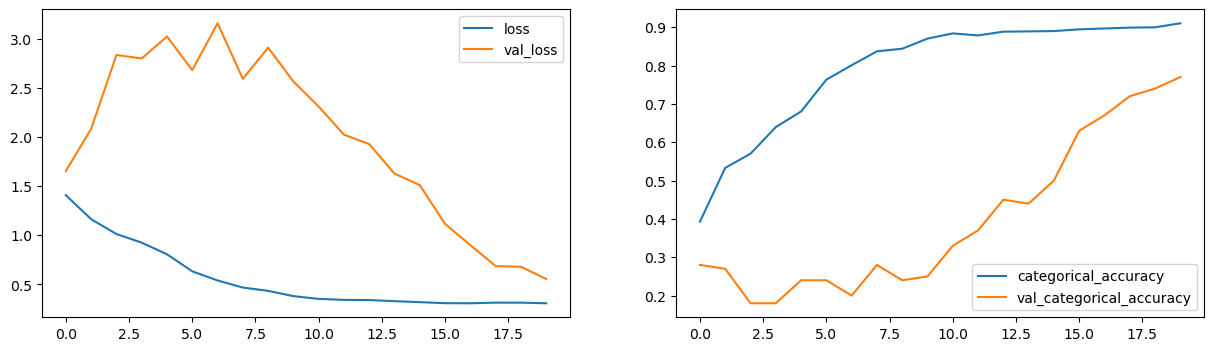

In [26]:
plot(model_3)

***Observations:***

After introducing rotation in the augmentation phase, the training accuracy experienced a slight decrease to 91%, while the validation accuracy rose to 77%. We are now exploring transfer learning to assess whether it can further enhance the validation accuracy.

### Model 4 - LSTM + RNN with Transfer Learning

In [31]:
class RNNCNN_TL_LSTM(ModelBuilderWithRotation):
    
    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):
        mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer, 
                input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimizer = tf.keras.optimizers.legacy.Adam()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [32]:
rnn_cnn_4 = RNNCNN_TL_LSTM()
rnn_cnn_4.initialize_path(base_path)
rnn_cnn_4.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_4.initialize_hyperparameters(number_of_sample_frames=16, batch_size=5, num_epochs=20)
rnn_cnn_model_4 = rnn_cnn_4.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_65 (TimeD  (None, 16, 3, 3, 1024)    3228864   
 istributed)                                                     
                                                                 
 time_distributed_66 (TimeD  (None, 16, 3, 3, 1024)    4096      
 istributed)                                                     
                                                                 
 time_distributed_67 (TimeD  (None, 16, 1, 1, 1024)    0         
 istributed)                                                     
                                                                 
 time_distributed_68 (TimeD  (None, 16, 1024)          0         
 istributed)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 128)              

In [33]:
print("Total Parameters: ", rnn_cnn_model_4.count_params())
model_4 = rnn_cnn_4.train_model(rnn_cnn_model_4, augment_data=True)

Total Parameters:  3840453
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.3211 - categorical_accuracy: 0.4449
Epoch 1: saving model to model_init_2024-04-0122_06_16.545050/model-00001-1.32109-0.44495-0.90250-0.68000.keras
133/133 [==============================] - 112s 840ms/step - loss: 1.3211 - categorical_accuracy: 0.4449 - val_loss: 0.9025 - val_categorical_accuracy: 0.6800 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.9344 - categorical_accuracy: 0.6290
Epoch 2: saving model to model_init_2024-04-0122_06_16.545050/model-00002-0.93443-0.62896-0.89073-0.61000.keras
133/133 [==============================] - 110s 833ms/step - loss: 0.9344 - categorical_accuracy: 0.6290 - val_loss: 0.8907 - val_categorical_accuracy: 0.6100 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.6445 - categorical_accuracy: 0.7504
Epoch 3: saving model to model_init_2024-04-0122_06_16.545050/model-00003-0.64447

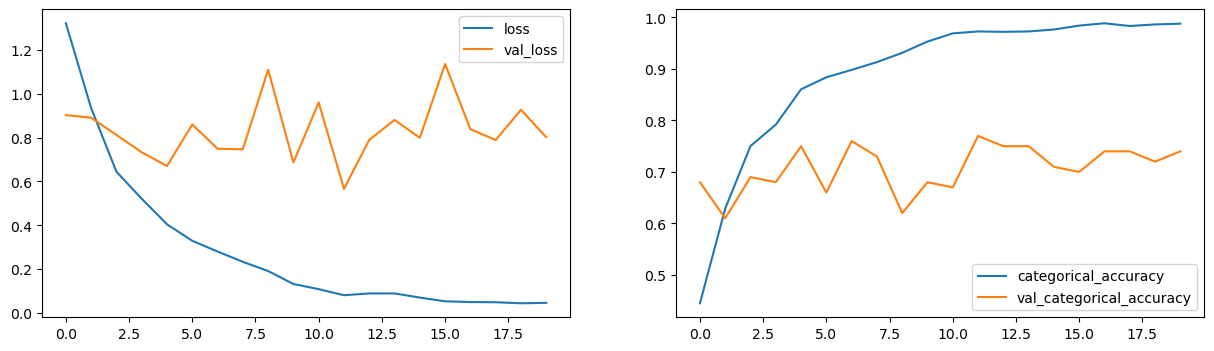

In [34]:
plot(model_4)

***Observations:***

Utilizing LSTM with transfer learning resulted in an enhancement of the training accuracy to 98.87%. However, despite the validation accuracy increasing to 74%, it still suggests potential overfitting. This may be attributed to the lack of training of MobileNet weights. Let's investigate if this issue is mitigated by employing GRU and transfer learning, while also training the weights from MobileNet.

### Model 5 - GRU + RNN with Transfer Learning (with trainable weights)

In [35]:
class RNNCNN_TL_GRU(ModelBuilderWithRotation):
    
    def model_definition(self, cells=64, dense_neurons=64, dropout=0.25):
        mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer, 
                input_shape=(self.number_of_sample_frames, self.image_height, self.image_width, self.channels)))
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        optimizer = tf.keras.optimizers.legacy.Adam()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [36]:
rnn_cnn_5 = RNNCNN_TL_GRU()
rnn_cnn_5.initialize_path(base_path)
rnn_cnn_5.initialize_image_props(image_height=120, image_width=120)
rnn_cnn_5.initialize_hyperparameters(number_of_sample_frames=16, batch_size=5, num_epochs=20)
rnn_cnn_model_5 = rnn_cnn_5.model_definition(cells=128, dense_neurons=128, dropout=0.25)
rnn_cnn_model_5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_69 (TimeD  (None, 16, 3, 3, 1024)    3228864   
 istributed)                                                     
                                                                 
 time_distributed_70 (TimeD  (None, 16, 3, 3, 1024)    4096      
 istributed)                                                     
                                                                 
 time_distributed_71 (TimeD  (None, 16, 1, 1, 1024)    0         
 istributed)                                                     
                                                                 
 time_distributed_72 (TimeD  (None, 16, 1024)          0         
 istributed)                                                     
                                                                 
 gru_1 (GRU)                 (None, 128)              

In [37]:
print("Total Parameters: ", rnn_cnn_model_5.count_params())
model_5 = rnn_cnn_5.train_model(rnn_cnn_model_5, augment_data=True)

Total Parameters:  3693253
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.2017 - categorical_accuracy: 0.4962
Epoch 1: saving model to model_init_2024-04-0212_23_32.667503/model-00001-1.20165-0.49623-0.64180-0.72000.keras
133/133 [==============================] - 284s 2s/step - loss: 1.2017 - categorical_accuracy: 0.4962 - val_loss: 0.6418 - val_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.7349 - categorical_accuracy: 0.6946
Epoch 2: saving model to model_init_2024-04-0212_23_32.667503/model-00002-0.73485-0.69457-0.57382-0.75000.keras
133/133 [==============================] - 277s 2s/step - loss: 0.7349 - categorical_accuracy: 0.6946 - val_loss: 0.5738 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.5543 - categorical_accuracy: 0.7624
Epoch 3: saving model to model_init_2024-04-0212_23_32.667503/model-00003-0.55425-0.762

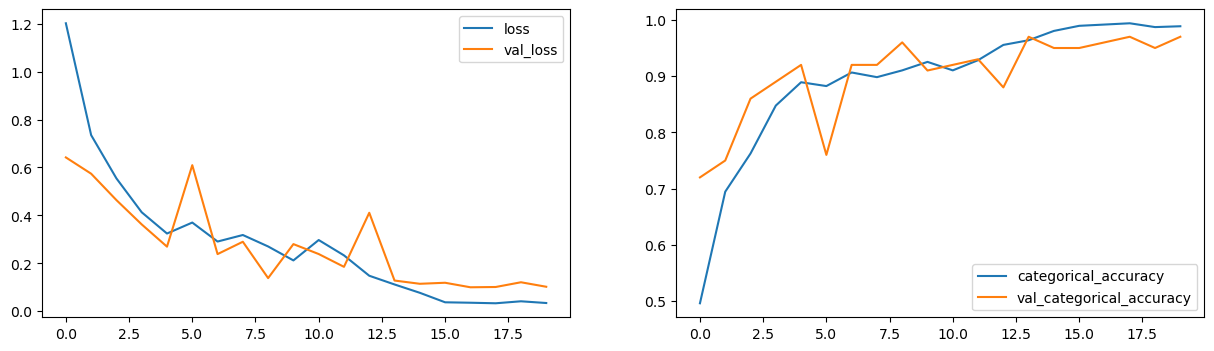

In [38]:
plot(model_5)

***Observations:***

By employing GRU and transfer learning with pre-trained weights, we observe a remarkable increase in the training accuracy to 99.40% and validation accuracy to 97%. This indicates successful resolution of overfitting, and the model performs well on the validation set. Hence, we can regard this as our final model for evaluation.

### Model Evaluation

In [45]:
from keras.models import load_model
model = load_model('final-model-00018-0.03309-0.99397-0.10102-0.97000.keras')

In [46]:
test_generator = RNNCNN_TL_GRU()
test_generator.initialize_path(base_path)
test_generator.initialize_image_props(image_height=120, image_width=120)
test_generator.initialize_hyperparameters(number_of_sample_frames=16, batch_size=5, num_epochs=1)

g = test_generator.generator(test_generator.val_path, test_generator.val_doc, augment=False)
batch_data, batch_labels= next(g)

In [47]:
batch_labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [48]:
print(np.argmax(model.predict(batch_data[:, :, :, :, :]), axis=1))

1/1 [==============================] - 1s 559ms/step
[1 2 4 1 2]
